*As of Project PyTHAGORA Alpha Release 7/24/2024, this project/lesson is known to be incomplete, early updates should include the creation and testing of this lesson.*

In [1]:
import numpy as np
import imageio as iio
import pandas as pd
import spectral as sp
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from stl import mesh
import os
from PDSnav import *
#from scipy.ndimage import map_coordinates
from scipy.interpolate import RBFInterpolator, Rbf, griddata

In [2]:
def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

In [4]:
'''
import requests
from bs4 import BeautifulSoup

def nav_html_dir(dir_url):
    nav = dir_url
    while input(f"Navigate to {nav}| Y or N") != "quit"or"Quit"or"N":
        if nav[-4:] == '.hdr':
            filename = ""
            for i in range(0,len(target)):
                if target[i] == '/':
                    filename = target[i+1:]
            response = requests.get(nav)
            if response.status_code == 200:
                with open(filename, 'wb') as file:
                    file.write(response.content)
                print(f"File contents at {nav} succesfully downloaded to file {filename}")
            else:
                print(f"Failed to Download File. Status code: {response.status_code}")
            return filename
        response = requests.get(nav)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            links = [a['href'] for a in soup.find_all('a', href=True)]
            links[0] = "Quit"
            for link in enumerate(links):
                print('| {:2} | {:<75} |'.format(*link))
            input_ = int(input("Navigate to:"))
            if input_ == 0:
                print("Left Directory")
                return
            else:
                target = links[input_]
                for i in range(0,len(nav)):
                    if dir_url[-i:] == target[:i]:
                        nav = dir_url + target[i:]
        else:
            print(f"Failed to retreive directory. Status code: {response.status_code}")
    return
'''

'\nimport requests\nfrom bs4 import BeautifulSoup\n\ndef nav_html_dir(dir_url):\n    nav = dir_url\n    while input(f"Navigate to {nav}| Y or N") != "quit"or"Quit"or"N":\n        if nav[-4:] == \'.hdr\':\n            filename = ""\n            for i in range(0,len(target)):\n                if target[i] == \'/\':\n                    filename = target[i+1:]\n            response = requests.get(nav)\n            if response.status_code == 200:\n                with open(filename, \'wb\') as file:\n                    file.write(response.content)\n                print(f"File contents at {nav} succesfully downloaded to file {filename}")\n            else:\n                print(f"Failed to Download File. Status code: {response.status_code}")\n            return filename\n        response = requests.get(nav)\n        if response.status_code == 200:\n            soup = BeautifulSoup(response.content, \'html.parser\')\n            links = [a[\'href\'] for a in soup.find_all(\'a\', href=True

In [5]:
#dir_url = 'https://pds-geosciences.wustl.edu/mgs/mgs-m-mola-5-megdr-l3-v1/'
#nav_html_dir(dir_url)

In [3]:
#dir_url = 'https://pds-geosciences.wustl.edu/mgs/mgs-m-mola-5-megdr-l3-v1/mgsl_300x/extras/meg004'
#path = os.getcwd()
filename = 'megt90n000cb.hdr'
#path = 'megt90n000cb.hdr'
R_Mars = 3390e3; 
A  = 10; #scaling factor


MOLA = sp.open_image(filename)
#help(MOLA)
N_lat = MOLA.read_band(0).shape[0]
N_lon = MOLA.read_band(0).shape[1]
MOLA_data=MOLA.read_band(0)

if filename[10]=='c':
    h = 4
elif filename[10]=='e':
    h = 16
elif filename[10]=='f':
    h = 32
elif filename[10]=='g':
    h = 64
elif filename[10]=='h':
    h = 128

if filename[6]=='n':
    d = +1
elif filename[6]=='s':
    d = -1


lambda_0 = float(filename[7:10])
theta_0 = float(filename[4:6])*d
lambda_ = lambda_0 + np.arange(0,N_lon,1)/h
theta_ = theta_0 - np.arange(0,N_lat,1)/h
dlambda = lambda_[1]-lambda_[0]
dtheta = theta_[1]-theta_[0]

lambda_ = np.append(lambda_,(lambda_[-1]+dlambda))
theta_ = np.append(theta_,(theta_[-1]+dtheta))
MOLA_data = np.c_[MOLA_data, MOLA_data[:,0]]
MOLA_data = np.r_[MOLA_data, [MOLA_data[0]]]

az = lambda_*pi/180
el = theta_*pi/180
r = R_Mars

[az,el,r]=np.meshgrid(az,el,r)
[az,el,r] = [az.reshape(721,1441), el.reshape(721,1441),r.reshape(721,1441)]
r = r+A*MOLA_data


[x,y,z] = sph2cart(az,el,r)


In [7]:
# Ensure x, y, z have the same shape
assert x.shape == y.shape == z.shape

# Number of triangles: (rows-1) * (cols-1) * 2 for a quad mesh
num_triangles = (x.shape[0] - 1) * (x.shape[1] - 1) * 2
data = np.zeros(num_triangles, dtype=mesh.Mesh.dtype)

# Fill the data array with vertices
index = 0
for i in range(x.shape[0] - 1):
    for j in range(x.shape[1] - 1):
        # Triangle 1
        data['vectors'][index] = np.array([
            [x[i, j], y[i, j], z[i, j]],
            [x[i+1, j], y[i+1, j], z[i+1, j]],
            [x[i, j+1], y[i, j+1], z[i, j+1]]
        ])
        index += 1

        # Triangle 2
        data['vectors'][index] = np.array([
            [x[i+1, j], y[i+1, j], z[i+1, j]],
            [x[i+1, j+1], y[i+1, j+1], z[i+1, j+1]],
            [x[i, j+1], y[i, j+1], z[i, j+1]]
        ])
        index += 1

# Create the mesh
mars_mesh = mesh.Mesh(data)

# Optionally, save the mesh to a file
#mars_mesh.save('mars_mesh.stl')

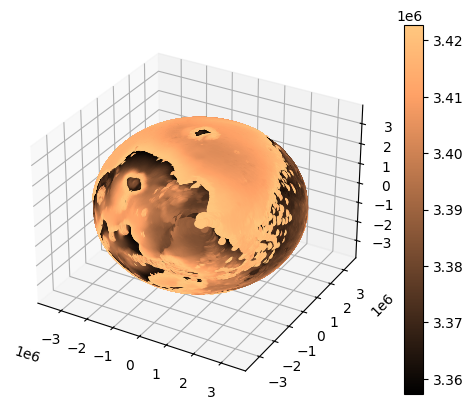

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
surf = ax.scatter(x, y, z, c=r, cmap=cm.copper)
fig.colorbar(surf, ax=ax)
plt.show()

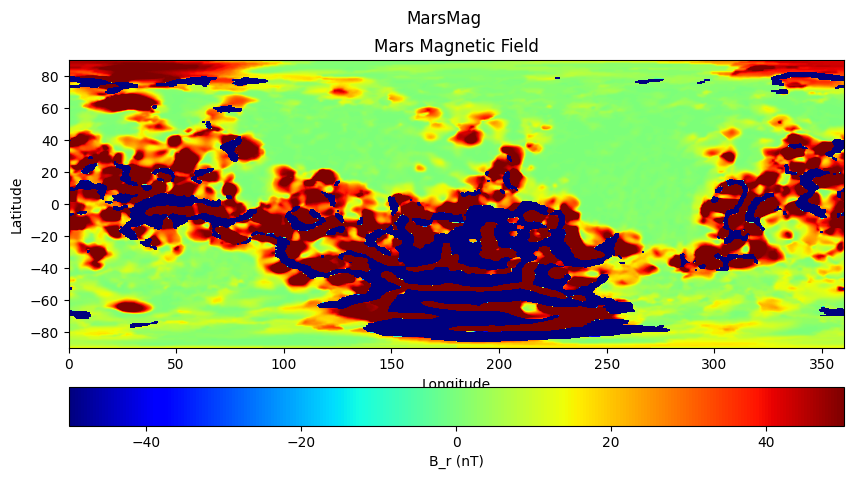

In [9]:
Field_Data = np.genfromtxt("LILLIS_ER_MAP.TAB")
Field_Data = Field_Data.reshape(720*360,1)
Field_Data = Field_Data.reshape(360,720)

dl = 0.5
lat = np.arange(-90+dl/2, 90, dl)
lon = np.arange(0+dl/2, 360, dl)

lon, lat = np.meshgrid(lon, lat)

# Flatten the data
lat_flat = lat.flatten()
lon_flat = lon.flatten()
field_flat = Field_Data.flatten()

# Define the grid to interpolate on
grid_lon = np.linspace(lon.min(), lon.max(), 720)
grid_lat = np.linspace(lat.min(), lat.max(), 360)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Perform interpolation
field_interped = griddata(
    (lon_flat, lat_flat),  # Coordinates of data points
    field_flat,            # Values at data points
    (grid_lon, grid_lat),  # Grid points where interpolation is needed
    method='cubic'         # Interpolation method (options: 'linear', 'cubic', 'nearest')
)

# Plot the result
'''
plt.figure(figsize=(10, 5))
plt.imshow((grid_lon[1,:], grid_lat[:,1], field_interped), vmin=-50, vmax=50)
#plt.contourf(grid_lon, grid_lat, field_interped, cmap='jet')
plt.colorbar(label='Interpolated Field')
plt.title('2D Griddata Interpolation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
'''
figName = 'MarsMag'
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(figName)

# Create the 2D plot
im = ax.imshow(field_interped, extent=[0, 360, -90, 90], origin='lower', cmap='jet')

# Add color bar and adjust settings
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('B_r (nT)')
Blim = 50
im.set_clim(-Blim, Blim)

# Add title and labels
ax.set_title('Mars Magnetic Field')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust the axes and appearance
ax.set_aspect('auto')

plt.show()

In [25]:
plt.cm.jet(field_interped).T.shape



(4, 720, 360)

ValueError: 'c' argument has 259200 elements, which is inconsistent with 'x' and 'y' with size 1038961.

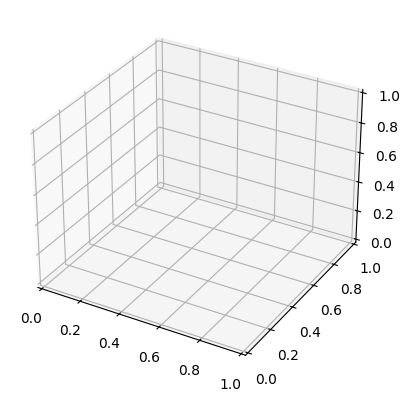

In [31]:
#%matplotlib ipympl
figName = 'MarsMag'
# Create a figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot with interpolated data
surf = ax.scatter(x, y, z, c=field_interped, cmap = plt.cm.jet(field_interped))

# Create colorbar
m = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=-50, vmax=50))
m.set_array(field_interped)
hcb = fig.colorbar(m, orientation='horizontal', pad=0.1, shrink=0.5, aspect=10,ax = ax)
hcb.set_label('B_r (nT)')

# Set the colormap and color limits
surf.set_clim([-50, 50])
ax.set_title('B_r (nT)')

# Adjust colorbar tick labels
hcb.set_ticks(np.linspace(-50, 50, num=11))
hcb.ax.set_xticklabels([f'{tick:.0f}' for tick in hcb.get_ticks()])

# Show the plot
plt.show()